# Load and process data

In [7]:
import geopandas as gpd
import pandas as pd
import osmnx as ox
import yaml
import matplotlib.pyplot as plt
import contextily as cx
from datetime import datetime
from src import graph_functions as gf
from src import simplification_functions as sf
from src import evaluation_functions as ef

**Load settings for analysis:**

In [8]:
with open(r'../config.yml') as file:

    parsed_yaml_file = yaml.load(file, Loader=yaml.FullLoader)

    study_area = parsed_yaml_file['study_area']
    study_area_poly_fp = parsed_yaml_file['study_area_poly']
    study_crs = parsed_yaml_file['study_crs']

    use_custom_filter = parsed_yaml_file['use_custom_filter']
    custom_filter = parsed_yaml_file['custom_filter']
    standard_filter = parsed_yaml_file['standard_filter']
    osm_way_tags = parsed_yaml_file['osm_way_tags']

    reference_comparison = parsed_yaml_file['reference_comparison']
    reference_fp = parsed_yaml_file['reference_fp']
    reference_geometries = parsed_yaml_file['reference_geometries']
    column_bidirectional = parsed_yaml_file['column_bidirectional']
    
    
print('Settings loaded!')

ef.check_settings_validity(study_area, study_area_poly_fp, study_crs, use_custom_filter, custom_filter, reference_comparison,
    reference_fp, reference_geometries, column_bidirectional)


Settings loaded!


## Load data defining study area

The size of the study area is 181.38 square kilometers


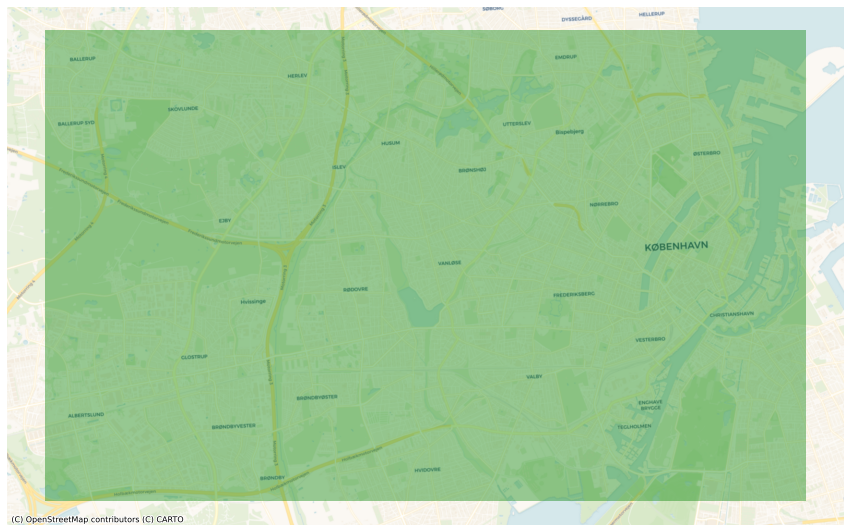

In [6]:
# Read polygon for study area
study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print('Please assign a crs to the study area polygon!')

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f'The size of the study area is {area / 1000000:.2f} square kilometers')

fig, ax = plt.subplots(1, figsize=(15,15))

study_area_poly.plot(ax=ax, color='green', alpha=0.4)

ax.set_axis_off()

cx.add_basemap(
    ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager)

## Load OSM data

Depending on the size of your study area, getting data through OSMnx can take a little while.

In [9]:
# TODO: Method for getting graph based on custom filter?

ox.utils.config(use_cache=True, 
    useful_tags_way = osm_way_tags)

graph_osm = ox.graph_from_polygon(study_area_poly.to_crs('EPSG:4326').loc[0, 'geometry'], network_type='bike', simplify=False, retain_all=True, truncate_by_edge=False, clean_periphery=True)

print('Data retrieved!')

# Project graph to chosen crs
graph_osm = ox.project_graph(graph_osm, to_crs=study_crs)

# Get osm_edges and osm_nodes
osm_nodes, osm_edges = ox.graph_to_gdfs(graph_osm)

# Clean up column names (removing ':' and upper case letters)
osm_edges = gf.clean_col_names(osm_edges)
osm_nodes = gf.clean_col_names(osm_nodes)

# Add attribute on whether cycling infra exist or not (to be used by e.g. simplification function)
osm_edges['cycling_infrastructure'] = 'no'

queries = ["highway == 'cycleway'",
        "cycleway in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
        "cycleway_left in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']", # should shared_busway be included?
        "cycleway_right in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
        "cycleway_both in ['lane','track','opposite_lane','opposite_track','shared_lane','designated','crossing','share_busway']",
        "bicycle_road == 'yes'"]

for q in queries:
    ox_filtered = osm_edges.query(q)

    osm_edges.loc[ox_filtered.index, 'cycling_infrastructure'] = 'yes'

osm_edges.cycling_infrastructure.value_counts()

# Overview of data from OSM
graph_area = ef.get_graph_area(osm_nodes, study_area_poly, study_crs)
print(f'The graph covers an area of {graph_area/ 1000000:.2f} square kilometers')

# Define whether cycling infrastructure is in both or one direction and whether it is one- or bidirectional
osm_edges = ef.simplify_cycling_tags(osm_edges)

# Measure the length of cycling infrastructure (!=from length of edges)
osm_edges['infrastructure_length'] = osm_edges.apply(lambda x: ef.measure_infrastructure_length(edge = x.geometry, 
                                                        geometry_type=x.cycling_geometries, bidirectional=x.cycling_bidirectional, cycling_infrastructure=x.cycling_infrastructure), axis=1)

cycling_edges = osm_edges.loc[osm_edges.cycling_infrastructure == 'yes']
print(f'The length of the OSM network with cycling infrastructure is {cycling_edges.infrastructure_length.sum()/1000 :.2f} kilometers')

cycling_graph, cycling_nodes = ef.create_cycling_network(cycling_edges, osm_nodes, graph_osm, return_nodes=True)
print('Created network only with cycling infrastructure!')


The graph covers an area of 180.18 square kilometers
False    37566
True     17358
Name: cycling_bidirectional, dtype: int64
true_geometries    29736
centerline         25188
Name: cycling_geometries, dtype: int64
The length of the OSM network is 1750.52 kilometers


OSM networks saved!


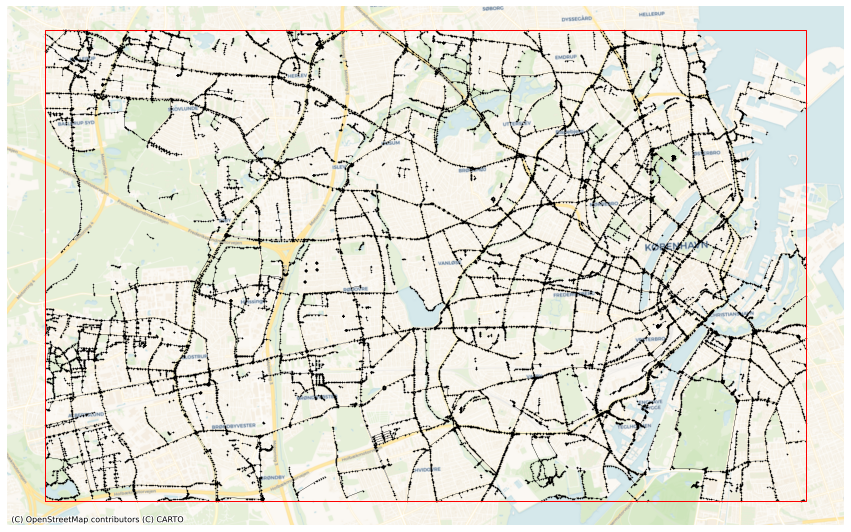

In [13]:
# Simplify network
graph_osm_simple = sf.simplify_graph(cycling_graph, attributes=['cycling_infrastructure','cycling_bidirectional','cycling_geometries'])

# Save data
ox.save_graphml(cycling_graph, f'../data/osm_{study_area}.graphml')
ox.save_graphml(graph_osm_simple, f'../data/osm_{study_area}_simple.graphml')
print('OSM networks saved!')

# TODO: Save results of simplifying network

# Save time for when OSM data was loaded
current_time = datetime.now().strftime('%m/%d/%Y, %H:%M:%S')
f = open('../osm_meta.txt', 'a')
f.write(f'OSM data for {study_area} downloaded at: {current_time} \n')
f.close()

# Plot network
fig, ax = plt.subplots(1, figsize=(15,15))

cycling_edges.plot(ax=ax, color='black', linewidth=0.2)
cycling_nodes.plot(ax=ax, color='black', markersize=0.2)

study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

cx.add_basemap(
    ax=ax, 
    crs=study_area_poly.crs, 
    source=cx.providers.CartoDB.Voyager
)
ax.set_axis_off()

## Load reference data

In [ ]:
if reference_comparison:

    # Read reference data
    ref_data = gpd.read_file(reference_fp)

    # Reproject
    if ref_data.crs == None:
        print('Please assign a crs to the study area polygon!')

    if ref_data.crs != study_crs:
        ref_data = ref_data.to_crs(study_crs)

    assert ref_data.crs == study_crs

    # Clip reference data to study area poly
    ref_data = ref_data.clip(study_area_poly)

    # Convert to osmnx graph object
    graph_ref = gf.create_osmnx_graph(ref_data)

    ref_nodes, ref_edges = ox.graph_to_gdfs(graph_ref)

    # Overview of data
    graph_area = ef.get_graph_area(ref_nodes, study_area_poly, study_crs)
    print(f'The reference data covers an {graph_area / 1000000:.2f} square kilometers')


    # TODO: Incorporate whether reference data is double or single geometries! Use function that creates a infrastructure length column?
    print(f'The length of the reference network is {ref_edges.unary_union.length/1000 :.2f} kilometers')

    # Plot network
    fig, ax = plt.subplots(1, figsize=(15,15))

    ref_edges.plot(ax=ax, color='purple', linewidth=0.2)
    ref_nodes.plot(ax=ax, color='purple', markersize=0.2)

    study_area_poly.plot(ax=ax, edgecolor='red', facecolor='None', linewidth=1)

    ax.set_axis_off()

    cx.add_basemap(
        ax, 
        crs=study_area_poly.crs, 
        source=cx.providers.CartoDB.Voyager
    )

    # Simplify - the graph is simplified as much as possible, but without combining edges with conflicting values of cycling infrastructure types
    graph_ref_simple = sf.momepy_simplify_graph(graph_ref, attributes=['vejklasse'])

    # Save data
    ox.save_graphml(graph_ref, f'../data/ref_{study_area}.graphml')

    #ox.save_graphml(graph_ref_simple, f'../data/ref_{study_area}_simple.graphml')

    print('Reference networks saved!')
    
else:
    print('The analysis will not make use of a reference data set. Please update config settings if a extrinsic analysis of OSM data quality should be performed.')

